In [27]:
#MSE vs サーチケース
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

#reaction length
df = pd.read_excel('/mnt/c/CEA/all_mixtureexp15.xlsx')

l1=['Fuel','Diluent','Equivalentratio','CoefficientDiluent','Oxidizer','diluentratio','P0', 'H0[KJ/kg]', 'M0[kg/kmol]', 'γ0[-]', 'pcj[bar]', 'Tcj[K]',
       'Hcj[KJ/kg]', 'Mcj[kg/kmol]', 'γcj[-]', 'Mcj[-]', 'Tvn[K]','Ea[KJ/kg]', 'theta' , 'Vcj[m/s]','Lr','Lc']

XpcaFLRDED = pd.DataFrame({'P0':df['P0']})

for i in range(len(l1)):
    XpcaFLRDED[l1[i]]=df[l1[i]]

XpcaFLRDED = XpcaFLRDED[~( XpcaFLRDED['inductionlength'] == 0)]

def calc_double(n):
    return n*1000000

XpcaFLRDED['inductionlength'] = list(map(calc_double,XpcaFLRDED['inductionlength']))

XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  5)]
XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  10)]
#XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'Ar') | ~( XpcaFLRDED['Lc'] ==  20)]
XpcaFLRDED =  XpcaFLRDED[~( XpcaFLRDED['Diluent'] == 'Kr')]

print(len(XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['Diluent'] == 'Ar')]))

dfC2H2N2train = XpcaFLRDED[~( XpcaFLRDED['Fuel'] == 'C2H2') | ~( XpcaFLRDED['Diluent'] == 'N2')]
dfC2H2N2test = XpcaFLRDED[( XpcaFLRDED['Fuel'] == 'C2H2') & ( XpcaFLRDED['Diluent'] == 'N2')]

dfC2H2Hetrain = dfC2H2N2train[~( dfC2H2N2train['Fuel'] == 'C2H2') | ~( dfC2H2N2train['Diluent'] == 'He')]
dfC2H2Hetest = dfC2H2N2train[( dfC2H2N2train['Fuel'] == 'C2H2') & ( dfC2H2N2train['Diluent'] == 'He')]

dfC2H6N2Otrain =  dfC2H2Hetrain[~( dfC2H2Hetrain['Fuel'] == 'C2H6') | ~( dfC2H2Hetrain['Oxidizer'] == 'N2O')]
dfC2H6N2Otest = dfC2H2Hetrain[( dfC2H2Hetrain['Fuel'] == 'C2H6') & ( dfC2H2Hetrain['Oxidizer'] == 'N2O')]

dfC3H6O2train =  dfC2H6N2Otrain[~( dfC2H6N2Otrain['Fuel'] == 'C3H6') | ~( dfC2H6N2Otrain['Oxidizer'] == 'O2')]
dfC3H6O2test = dfC2H6N2Otrain[( dfC2H6N2Otrain['Fuel'] == 'C3H6') & ( dfC2H6N2Otrain['Oxidizer'] == 'O2')]

dfC3H6N2Otrain =  dfC3H6O2train[~( dfC3H6O2train['Fuel'] == 'C3H6') | ~( dfC3H6O2train['Oxidizer'] == 'N2O')]
dfC3H6N2Otest = dfC3H6O2train[( dfC3H6O2train['Fuel'] == 'C3H6') & ( dfC3H6O2train['Oxidizer'] == 'N2O')]

dftrainval = dfC3H6N2Otrain.sample(frac=1)
P0range = '0.6>P0>0.3'
P0range1 = '0.6>P0>0.3'

X_train = dftrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lc','diluentratio'])

ss = StandardScaler()
sX_train = ss.fit_transform(X_train)
sX_train = pd.DataFrame(sX_train,columns=X_train.columns)


116


In [28]:
#dftrainval1 = dftrainval[( dftrainval['Equivalentratio'] == 1)]
#dftrainval2 = dftrainval1[(dftrainval1['Diluent'].isnull()) | (dftrainval1['diluentratio'] == 50)]
X_train = dftrainval.drop(columns=['Diluent','Fuel','Equivalentratio','CoefficientDiluent','Oxidizer','Lc','diluentratio'])
print(len(dftrainval))
X_train = X_train.query(P0range)
sX_train = ss.transform(X_train)

581


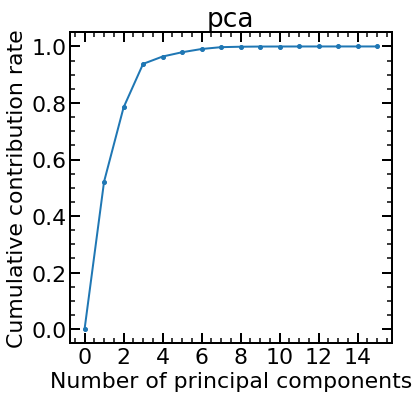

In [29]:
from sklearn.decomposition import PCA,KernelPCA
# データの分布を主成分分析（PCA）で表現してみる
pca = PCA()
#pca  = KernelPCA(n_components=2,  kernel='rbf', gamma=20.0)
X_train_pca = pca.fit_transform(sX_train)

import matplotlib.ticker as ticker
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.title("pca")
plt.tight_layout()
plt.savefig("gurafu2(研究報告).png")

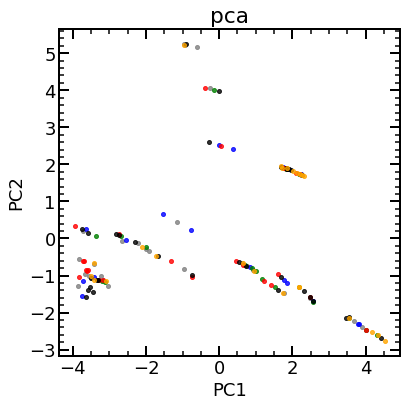

<Figure size 432x288 with 0 Axes>

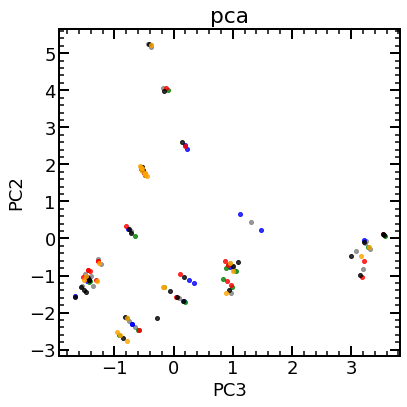

<Figure size 432x288 with 0 Axes>

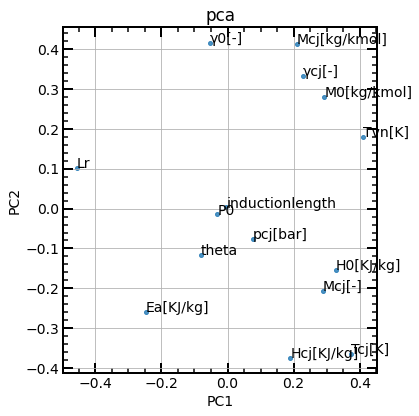

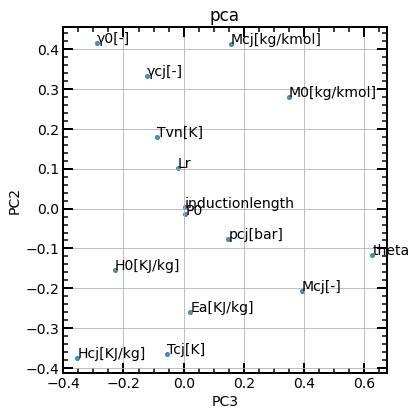

In [30]:
from sklearn.decomposition import PCA,KernelPCA
pca = PCA(n_components=4)

X_train_pca = pca.fit_transform(sX_train)
Diluent=list(dftrainval['Diluent'])
Fuel=list(dftrainval['Fuel'])
x1=[]
x2=[]
x3=[]
x4=[]
x5=[]
x6=[]
x7=[]
y1=[]
y2=[]
y3=[]
y4=[]
y5=[]
y6=[]
y7=[]
z1=[]
z2=[]
z3=[]
z4=[]
z5=[]
z6=[]
z7=[]
k1=[]
k2=[]
k3=[]
k4=[]
k5=[]
k6=[]
k7=[]
pc1=X_train_pca[:, 0]
pc2=X_train_pca[:, 1]
pc3=X_train_pca[:, 2]
pc4=X_train_pca[:, 3]

for i in range(len(sX_train)):
    if Fuel[i]=='H2':
        markers1='o'
        col1='grey'
        x1.append(pc1[i])
        y1.append(pc2[i])
        z1.append(pc3[i])
        k1.append(pc4[i])
    
    elif Fuel[i]=='C2H2':
    
        if Diluent[i]=='Ar':
            markers2='o'
            col2='red'
            x2.append(pc1[i])
            y2.append(pc2[i])
            z2.append(pc3[i])
            k2.append(pc4[i])

        else:
            markers3='o'
            col3='black'
            x3.append(pc1[i])
            y3.append(pc2[i])
            z3.append(pc3[i])
            k3.append(pc4[i])

    elif Fuel[i]=='C2H4':
        if Diluent[i]=='Ar':
            markers4='o'
            col4='blue'
            x4.append(pc1[i])
            y4.append(pc2[i])
            z4.append(pc3[i])
            k4.append(pc4[i])

        else:
            markers5='o'
            col5='orange'
            x5.append(pc1[i])
            y5.append(pc2[i])
            z5.append(pc3[i])
            k5.append(pc4[i])

    else:
        markers6='o'
        col6='green'
        x6.append(pc1[i])
        y6.append(pc2[i])
        z6.append(pc3[i])
        k6.append(pc4[i])

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5


plt.scatter(x1,y1, alpha=0.8, c=col1,marker=markers1)
plt.scatter(x4,y4, alpha=0.8, c=col4,marker=markers4)
plt.scatter(x6,y6, alpha=0.8, c=col6,marker=markers6)
plt.scatter(x2,y2, alpha=0.8, c=col2,marker=markers2)
plt.scatter(x3,y3, alpha=0.8, c=col3,marker=markers3)
plt.scatter(x5,y5, alpha=0.8, c=col5,marker=markers5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("pca")
#plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("gurafu1(研究報告).png")

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

plt.scatter(z1,y1, alpha=0.8, c=col1,marker=markers1)
plt.scatter(z4,y4, alpha=0.8, c=col4,marker=markers4)
plt.scatter(z6,y6, alpha=0.8, c=col6,marker=markers6)
plt.scatter(z2,y2, alpha=0.8, c=col2,marker=markers2)
plt.scatter(z3,y3, alpha=0.8, c=col3,marker=markers3)
plt.scatter(z5,y5, alpha=0.8, c=col5,marker=markers5)
plt.xlabel("PC3")
plt.ylabel("PC2")
plt.title("pca")
#plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("gurafu1(研究報告).png")

plt.figure(figsize=(6,6))
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5
for x, y, name in zip(pca.components_[0], pca.components_[1], X_train.columns[0:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("pca")
plt.grid(True)
plt.tight_layout()


plt.figure(figsize=(6,6))
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4.0

plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2.0

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5
for x, y, name in zip(pca.components_[2], pca.components_[1], X_train.columns[0:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[2], pca.components_[1], alpha=0.8)
plt.xlabel("PC3")
plt.ylabel("PC2")
plt.title("pca")
plt.grid(True)
plt.tight_layout()
